In [30]:
import numpy as np
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot

from tqdm import tqdm
import torch
import pickle

from helpers.data import get_pdf_toy, read_in_data
from helpers.ansatz import q, get_factorial_cache, get_taylor_expanded_ansatz

# Exponential MLE and MSE

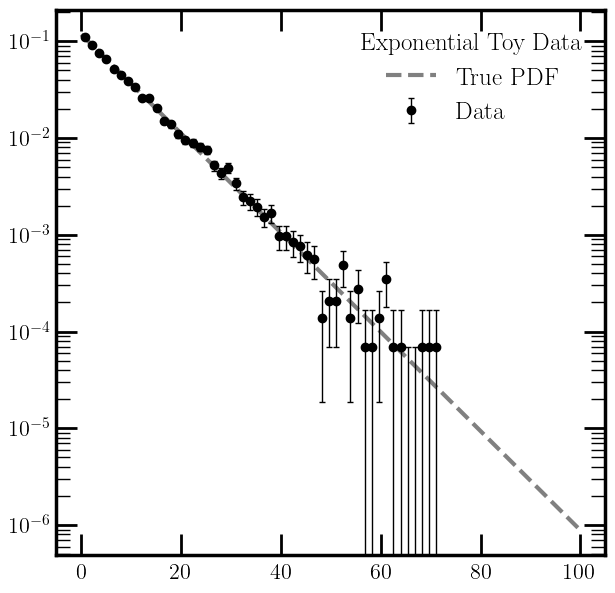

In [31]:
N = 10000
alpha_true = 0.118

# Sample from an exponential distribution
data = np.random.exponential(1/alpha_true, N)

# Plot histogram as points with errors
bins = 50
fig, ax = newplot("full")

weights = np.ones_like(data)
counts, bin_edges = np.histogram(data, bins=bins, weights=weights)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])    
errs = np.sqrt(counts + 1) / counts.sum() / (bin_edges[1:] - bin_edges[:-1])
counts = counts / counts.sum() / (bin_edges[1:] - bin_edges[:-1])


ts = np.linspace(0, 100, 10000)
pdf = alpha_true * np.exp(-alpha_true * ts)

ax.plot(ts, pdf, color='grey', ls = "--", label = "True PDF")

ax.errorbar(bin_centers, counts, yerr=errs, fmt='o', color='black', lw=1, capsize=2, label = "Data")

plt.legend(loc = "upper right", title = "Exponential Toy Data")
plt.yscale("log")

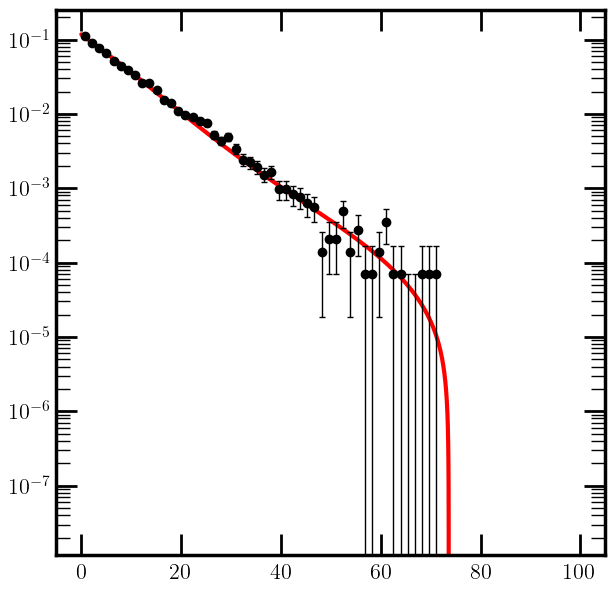

In [32]:
outfile_name = f"exponential_2_3d"
device = "cpu"
save_dict = {}

with open(f"output_final/{outfile_name}_config", "rb") as ifile:
    save_dict["configs"] = pickle.load(ifile)
   
losses = np.load(f"output_final/{outfile_name}_losses.npy")
g_coeffs_log = np.load(f"output_final/{outfile_name}_g_coeffs.npy")
theta_log = np.load(f"output_final/{outfile_name}_theta.npy")


distribution = save_dict["configs"]["distribution"]
order_to_match = save_dict["configs"]["order_to_match"]
name = save_dict["configs"]["name"]
mstar = save_dict["configs"]["mstar"]
run_toy = save_dict["configs"]["run_toy"]

max_M, max_N = g_coeffs_log[0].shape

factorial_cache_info = get_factorial_cache(max_M, max_N, mstar, device)



t_min = ts[0]
t_max = ts[-1]
torch_ts = torch.tensor(ts, device=device)
alpha_tensor = torch.tensor([alpha_true], device=device)
q_vals = q(torch_ts, alpha_tensor, torch.tensor(g_coeffs_log[-1], device=device), 
                                         torch.tensor(theta_log[-1], device=device), mstar, t_min, t_max, device, factorial_cache_info).detach().cpu().numpy()

fig, ax = newplot("full")
plt.plot(ts, q_vals, color = "red")
ax.errorbar(bin_centers, counts, yerr=errs, fmt='o', color='black', lw=1, capsize=2, label = "Data")

plt.yscale("log")

In [33]:
def compute_log_likelihood(data, alpha, g_coeffs, theta):

    q_vals = q(torch.tensor(data, device=device), torch.tensor(alpha, device=device), torch.tensor(g_coeffs, device=device), 
               torch.tensor(theta, device=device), mstar, t_min, t_max, device, factorial_cache_info).detach().cpu().numpy()

    return -2 * np.sum(np.log(q_vals))

g_coeffs = g_coeffs_log[-1]
theta = theta_log[-1]

g_coeffs[:,-1] = np.abs(g_coeffs[:,-1])
g_coeffs = np.zeros_like(g_coeffs)
g_coeffs[0, 0 ] = 1
print(g_coeffs)

alphas = np.linspace(0.11, 0.13, 1000)
likelihoods = np.array([compute_log_likelihood(data, alpha, g_coeffs, theta) for alpha in alphas])
min_likelihood = np.min(likelihoods)
alpha_hat0 = alphas[np.argmin(likelihoods)]
likelihoods = likelihoods - min_likelihood

# Get the two points where the likelihood is 1
alpha_1 = alphas[np.argmin(likelihoods >= 1)]
alpha_2 = alphas[::-1][np.argmin(likelihoods[::-1] >= 1)]

print(alpha_1, alpha_2)
# print(likelihoods)

[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
0.11572572572572573 0.11804804804804805


In [34]:
# run 100 pseudoexperiments

alpha_hats = []
cover = 0
for i in range(100):

    alphas = np.linspace(0.11, 0.13, 1000)

    data = np.random.exponential(scale=1/alpha_true, size=10000)
    likelihoods = np.array([compute_log_likelihood(data, alpha, g_coeffs, theta) for alpha in alphas])


    min_likelihood = np.min(likelihoods)
    alpha_hat = alphas[np.argmin(likelihoods)]
    alpha_hats.append(alpha_hat)
    likelihoods = likelihoods - min_likelihood

    min_alpha = alphas[np.argmin(likelihoods >= 1)]
    max_alpha = alphas[::-1][np.argmin(likelihoods[::-1] >= 1)]

    # check if alpha_true is contained
    if alpha_true > min_alpha and alpha_true < max_alpha:
        cover += 1

    print(f"Pseudoexperiment {i}: Alpha Hat = {alpha_hat}, Min Alpha = {min_alpha}, Max Alpha = {max_alpha}")


Pseudoexperiment 0: Alpha Hat = 0.11716716716716717, Min Alpha = 0.11602602602602603, Max Alpha = 0.11834834834834836
Pseudoexperiment 1: Alpha Hat = 0.11734734734734735, Min Alpha = 0.11620620620620621, Max Alpha = 0.11852852852852853
Pseudoexperiment 2: Alpha Hat = 0.11964964964964965, Min Alpha = 0.11846846846846847, Max Alpha = 0.12083083083083083
Pseudoexperiment 3: Alpha Hat = 0.11896896896896897, Min Alpha = 0.11778778778778778, Max Alpha = 0.12015015015015015
Pseudoexperiment 4: Alpha Hat = 0.11922922922922924, Min Alpha = 0.11804804804804805, Max Alpha = 0.12041041041041041
Pseudoexperiment 5: Alpha Hat = 0.11624624624624624, Min Alpha = 0.11508508508508508, Max Alpha = 0.11738738738738738
Pseudoexperiment 6: Alpha Hat = 0.11914914914914915, Min Alpha = 0.11796796796796796, Max Alpha = 0.12033033033033033
Pseudoexperiment 7: Alpha Hat = 0.11752752752752753, Min Alpha = 0.11636636636636637, Max Alpha = 0.11868868868868869
Pseudoexperiment 8: Alpha Hat = 0.11992992992992993, Min

KeyboardInterrupt: 

Coverage: 41 / 59
0.11572572572572573 0.11804804804804805


(0.0, 100.0)

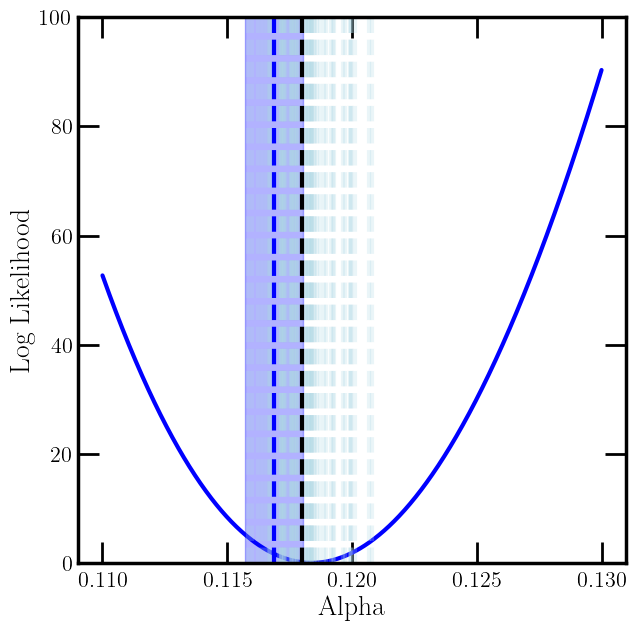

In [35]:
# Plot the log likelihoods
fig, ax = newplot("full")
ax.plot(alphas, likelihoods, color="blue")
ax.set_xlabel("Alpha")
ax.set_ylabel("Log Likelihood")

for alpha_hat in alpha_hats:
    ax.axvline(x=alpha_hat, color="lightblue", linestyle="--", alpha=0.25)

ax.axvline(x=alpha_true, color="black", linestyle="--", label="True Alpha")
ax.axvline(x=alpha_hat0, color="blue", linestyle="--", label="Estimated Alpha")

# Vertical Band between alpha1 and alpha2
ax.fill_betweenx(y=[-100, 100], x1=alpha_1, x2=alpha_2, color="blue", alpha=0.3)



print(f"Coverage: {cover} / {len(alpha_hats)}")

print(alpha_1, alpha_2)

plt.ylim(0, 100)


### Binned Likelihood

In [51]:
def binned_likelihood(data, alpha, g_coeffs, theta, bins=50):

    # Create histogram
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])    
    errs = np.sqrt(counts+1) / counts.sum() / (bin_edges[1:] - bin_edges[:-1])
    counts = counts / counts.sum() / (bin_edges[1:] - bin_edges[:-1])



    # Compute likelihood for each bin
    q_vals = q(torch.tensor(bin_centers, device=device), torch.tensor(alpha, device=device), 
               torch.tensor(g_coeffs, device=device), torch.tensor(theta, device=device), 
               mstar, t_min, t_max, device, factorial_cache_info).detach().cpu().numpy()


    # chi2
    chi2 = np.sum(((counts - q_vals) ** 2) / (errs ** 2 + 1e-10))
    return chi2


alphas = np.linspace(0.11, 0.13, 1000)

binned_likelihoods = np.array([binned_likelihood(data, alpha, g_coeffs, theta) for alpha in alphas])
alpha_hat0 = alphas[np.argmin(binned_likelihoods)]
binned_likelihoods = binned_likelihoods - np.min(binned_likelihoods)

alpha_1 = alphas[np.argmin(binned_likelihoods >= 1)]
alpha_2 = alphas[::-1][np.argmin(binned_likelihoods[::-1] >= 1)]

print(alpha_1, alpha_2)

0.11804804804804805 0.12049049049049049


In [ ]:
# run 100 pseudoexperiments

cover = 0
alpha_hats = []
for i in range(100):

    alphas = np.linspace(0.11, 0.13, 1000)

    data = np.random.exponential(scale=1/alpha_true, size=10000)
    likelihoods = np.array([binned_likelihood(data, alpha, g_coeffs, theta) for alpha in alphas])


    min_likelihood = np.min(likelihoods)
    alpha_hat = alphas[np.argmin(likelihoods)]
    alpha_hats.append(alpha_hat)
    likelihoods = likelihoods - min_likelihood

    min_alpha = alphas[np.argmin(likelihoods >= 1)]
    max_alpha = alphas[::-1][np.argmin(likelihoods[::-1] >= 1)]

    # check if alpha_true is contained
    if alpha_true > min_alpha and alpha_true < max_alpha:
        cover += 1

    print(f"Pseudoexperiment {i}: Alpha Hat = {alpha_hat}, Min Alpha = {min_alpha}, Max Alpha = {max_alpha}")


Pseudoexperiment 0: Alpha Hat = 0.11782782782782783, Min Alpha = 0.11666666666666667, Max Alpha = 0.11900900900900901
Pseudoexperiment 1: Alpha Hat = 0.11686686686686687, Min Alpha = 0.11570570570570571, Max Alpha = 0.11806806806806808
Pseudoexperiment 2: Alpha Hat = 0.11972972972972973, Min Alpha = 0.11854854854854854, Max Alpha = 0.12093093093093094
Pseudoexperiment 3: Alpha Hat = 0.11682682682682682, Min Alpha = 0.11560560560560561, Max Alpha = 0.11804804804804805
Pseudoexperiment 4: Alpha Hat = 0.12065065065065066, Min Alpha = 0.11946946946946947, Max Alpha = 0.12185185185185185
Pseudoexperiment 5: Alpha Hat = 0.11844844844844846, Min Alpha = 0.1172872872872873, Max Alpha = 0.11960960960960962
Pseudoexperiment 6: Alpha Hat = 0.12079079079079079, Min Alpha = 0.11956956956956957, Max Alpha = 0.12201201201201202
Pseudoexperiment 7: Alpha Hat = 0.12029029029029029, Min Alpha = 0.11908908908908909, Max Alpha = 0.12151151151151152
Pseudoexperiment 8: Alpha Hat = 0.11692692692692692, Min 

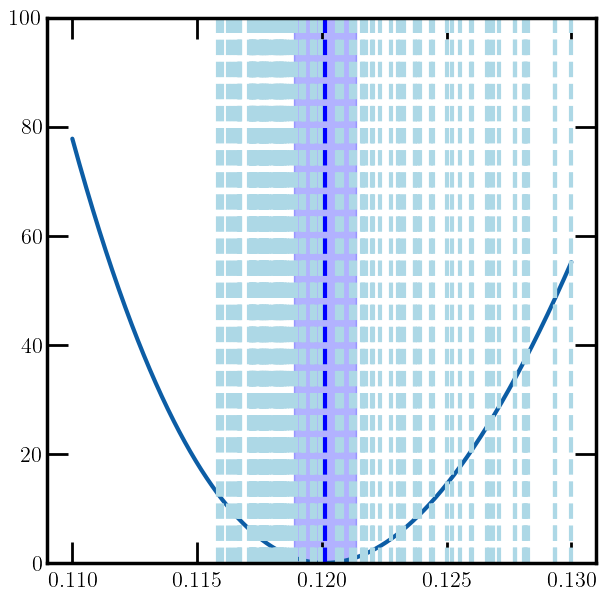

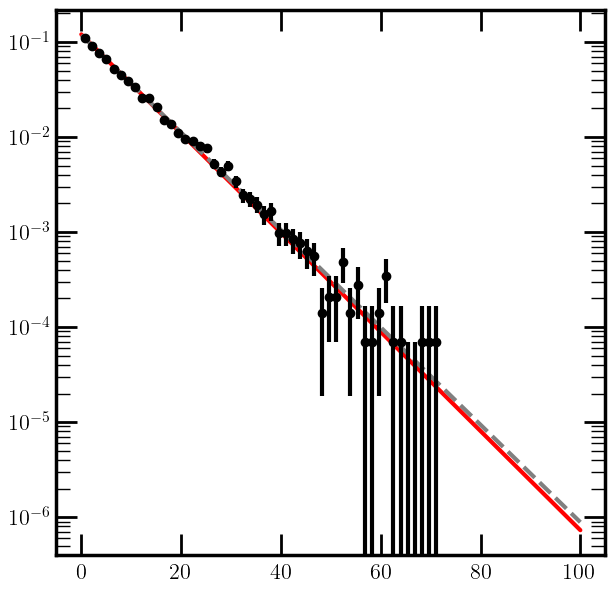

In [ ]:
fig, ax = newplot("full")
ax.plot(alphas, binned_likelihoods)


for i in range(100):
    ax.axvline(alpha_hats[i], color='lightblue', linestyle='--')


ax.axvline(alpha_hat0, color='b', linestyle='--')
ax.fill_betweenx(y=[-100, 100], x1=alpha_1, x2=alpha_2, color="blue", alpha=0.3)
plt.ylim(0, 100)

fig, ax = newplot("full")

# plot q at alpha_hat0
q_vals = q(torch.tensor(ts, device=device), torch.tensor(alpha_hat0, device=device), torch.tensor(g_coeffs, device=device), torch.tensor(theta, device=device), mstar, t_min, t_max, device, factorial_cache_info).detach().cpu().numpy()
plt.plot(ts, q_vals, color = "red")
q_vals_true = q(torch.tensor(ts, device=device), torch.tensor(alpha_true, device=device), torch.tensor(g_coeffs, device=device), torch.tensor(theta, device=device), mstar, t_min, t_max, device, factorial_cache_info).detach().cpu().numpy()
plt.plot(ts, q_vals_true, color = "grey", ls = "--")
plt.errorbar(bin_centers, counts, errs, fmt='o', color='black')
plt.yscale("log")


# print coverage
print(f"Coverage: {cover/100}")

In [ ]:
print(np.mean(alpha_hats))

0.12101093371363641


# Opal Data

In [ ]:
OPAL_DATA = np.array([
    [0.004849660523763337, 1.2754409769335133],
    [0.014742967992240535, 12.917232021709632],
    [0.02521823472356935, 18.534599728629576],
    [0.03491755577109602, 13.568521031207597],
    [0.04461687681862268, 9.660786974219809],
    [0.05470417070805042, 7.327001356852101],
    [0.0649854510184287, 5.671641791044777],
    [0.0748787584869059, 4.586160108548167],
    [0.08457807953443258, 3.7177747625508815],
    [0.0946653734238603, 3.066485753052916],
    [0.10494665373423859, 2.6594301221166887],
    [0.11483996120271578, 2.2523744911804577],
    [0.124733268671193, 1.9538670284938924],
    [0.13501454898157125, 1.6282225237449133],
    [0.14490785645004847, 1.4111261872455891],
    [0.15499515033947622, 1.2754409769335133],
    [0.16488845780795341, 1.1397557666214375],
    [0.17478176527643063, 0.9769335142469444],
    [0.1850630455868089, 0.8683853459972894],
    [0.1949563530552861, 0.7869742198100411],
    [0.20387972841901064, 0.678426051560379],])

OPAL_DATA_UPEPR = np.array([
    [0.0052376333656644, 1.5196743554952512],
    [0.015130940834141612, 13.405698778833106],
    [0.025024248302618804, 19.240162822252373],
    [0.035111542192046555, 13.839891451831749],
    [0.04519883608147429, 9.8236092265943],
    [0.0550921435499515, 7.435549525101765],
    [0.06517943743937923, 5.780189959294436],
    [0.07507274490785644, 4.694708276797829],
    [0.08516003879728418, 3.7991858887381262],
    [0.0950533462657614, 3.1478968792401645],
    [0.10514064015518912, 2.7408412483039335],
    [0.11522793404461687, 2.279511533242875],
    [0.12512124151309406, 2.008141112618727],
    [0.1352085354025218, 1.709633649932158],
    [0.14490785645004847, 1.492537313432834],
    [0.15518913676042673, 1.329715061058348],
    [0.16508244422890395, 1.194029850746265],
    [0.17497575169738114, 1.0583446404341927],
    [0.1850630455868089, 0.9226594301221169],
    [0.1949563530552861, 0.8412483039348722],
    [0.20387972841901064, 0.7055630936227963],])


OPAL_ERRORS = jnp.abs(OPAL_DATA_UPEPR[:,1] - OPAL_DATA[:,1])


NameError: name 'jnp' is not defined